In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

import statsmodels.api as sm
from course_1.risk_kit import Metrics
import nb.edhec_risk_kit_206 as erk
from backtesting import Backtester, EquallyWeighted, CapWeighted,\
GlobalMiminumVariance

import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.float_format = '{:.6f}'.format

m= Metrics()

In [14]:
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":]
ind_mcap = erk.get_ind_market_caps(30, weights=True)["1997":]

In [15]:
ind_rets.shape,  ind_mcap.shape

((264, 30), (264, 30))

In [16]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
ewr_ct = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew, \
                         microcap_threshold= 0.01, max_cw_mult=2, cap_weights=ind_mcap)
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.25)

btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, 'GMV-Shrink 0.25': mv_sh_r,\
                   "EW-CT": ewr_ct})
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
GMV-Sample,0.066306,0.117410,-0.741088,4.469212,0.055456,0.080583,0.300815,-0.421289
GMV-Shrink 0.25,0.068466,0.114572,-0.731285,4.264917,0.053884,0.077715,0.326630,-0.393410
EW-CT,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413


In [17]:
erk.summary_stats(btr.dropna()).loc["CW"]

Annualized Return          0.065196
Annualized Vol             0.151478
Skewness                  -0.556621
Kurtosis                   4.249894
Cornish-Fisher VaR (5%)    0.071076
Historic CVaR (5%)         0.098531
Sharpe Ratio               0.225949
Max Drawdown              -0.518990
Name: CW, dtype: float64

In [18]:
erk.summary_stats(btr.dropna()).loc["EW"]

Annualized Return          0.077614
Annualized Vol             0.158685
Skewness                  -0.538531
Kurtosis                   5.317042
Cornish-Fisher VaR (5%)    0.072485
Historic CVaR (5%)         0.106220
Sharpe Ratio               0.291838
Max Drawdown              -0.532980
Name: EW, dtype: float64

In [19]:
erk.summary_stats(btr.dropna()).loc["EW-CT"]

Annualized Return          0.076838
Annualized Vol             0.140774
Skewness                  -0.649872
Kurtosis                   4.664374
Cornish-Fisher VaR (5%)    0.065482
Historic CVaR (5%)         0.093766
Sharpe Ratio               0.323653
Max Drawdown              -0.487413
Name: EW-CT, dtype: float64

In [20]:
erk.summary_stats(btr.dropna()).loc["GMV-Sample"]

Annualized Return          0.066306
Annualized Vol             0.117410
Skewness                  -0.741088
Kurtosis                   4.469212
Cornish-Fisher VaR (5%)    0.055456
Historic CVaR (5%)         0.080583
Sharpe Ratio               0.300815
Max Drawdown              -0.421289
Name: GMV-Sample, dtype: float64

In [21]:
erk.summary_stats(btr.dropna()).loc["GMV-Shrink 0.25"]

Annualized Return          0.068466
Annualized Vol             0.114572
Skewness                  -0.731285
Kurtosis                   4.264917
Cornish-Fisher VaR (5%)    0.053884
Historic CVaR (5%)         0.077715
Sharpe Ratio               0.326630
Max Drawdown              -0.393410
Name: GMV-Shrink 0.25, dtype: float64

In [22]:
erk.tracking_error(ewr, cwr), erk.tracking_error(ewr_ct, cwr)

(0.18752094143646486, 0.11671015519949166)

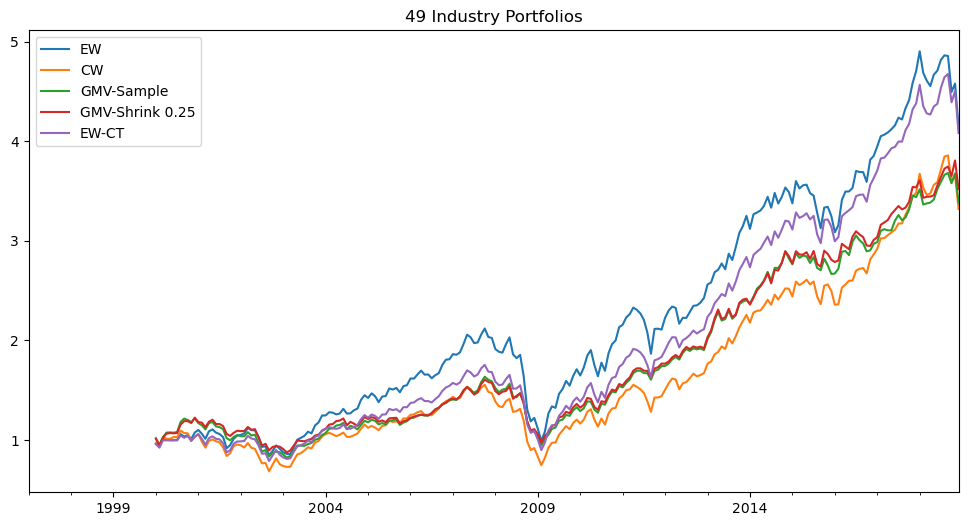

In [23]:
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios");

In [24]:
ewr2 = Backtester(EquallyWeighted(), estimation_window=36).run(ind_rets)
cwr2 = Backtester(CapWeighted(cap_weights=ind_mcap), estimation_window=36).run(ind_rets)
mv_s_r2 = Backtester(GlobalMiminumVariance(cov_estimator="sample_cov"), estimation_window=36).run(ind_rets)
mv_sh_r2 = Backtester(GlobalMiminumVariance(cov_estimator="shrink_cov" , delta=0.25), estimation_window=36).\
run(ind_rets)
btr2 = pd.DataFrame({"EW": ewr2, "CW": cwr2, "GMV-Sample": mv_s_r2, 'GMV-Shrink 0.25': mv_sh_r2})
erk.summary_stats(btr2.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
GMV-Sample,0.066306,0.117410,-0.741088,4.469212,0.055456,0.080583,0.300815,-0.421289
GMV-Shrink 0.25,0.068466,0.114572,-0.731285,4.264917,0.053884,0.077715,0.326630,-0.393410


In [25]:
erk.summary_stats(btr.dropna()).loc["EW-CT"]

Annualized Return          0.076838
Annualized Vol             0.140774
Skewness                  -0.649872
Kurtosis                   4.664374
Cornish-Fisher VaR (5%)    0.065482
Historic CVaR (5%)         0.093766
Sharpe Ratio               0.323653
Max Drawdown              -0.487413
Name: EW-CT, dtype: float64

In [26]:
erk.tracking_error(ewr, cwr), erk.tracking_error(ewr_ct, cwr)

(0.18752094143646486, 0.11671015519949166)